# Motivational Qualities of Songs for Daily Activities

In this assignment you will work on a study on song features and how they can be used as the basis for recommendations for specific daily activities. The study is:

* Kim, Y., Aiello, L.M. & Quercia, D. PepMusic: motivational qualities of songs for daily activities. EPJ Data Sci. 9, 13 (2020). https://doi.org/10.1140/epjds/s13688-020-0221-9

You can download the study from the above link. You can use the dataset provided by the authors, which is available inside the present folder at [data_archive_20190201.json](./data_archive_20190201.json).

---

> Panos Louridas, Associate Professor <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> louridas@aueb.gr

In [87]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [88]:
json_data = pd.read_json('./data_archive_20190201.json').transpose()
json_data.head()

,trackId,artists,songTitle,features,activityType,clusteringLabel,youtubeId,youtubeURL,spotifyTrackURL
0,3Vo4wInECJQuz9BIBMOu8i,"[Bruno Mars, Cardi B]",Finesse (Remix) [feat. Cardi B],"{'chordsScale': 'minor', 'chordsKey': 'F', 'bp...",exercising,intense,GIfa9Y4vxi8,https://www.youtube.com/watch?v=GIfa9Y4vxi8,https://open.spotify.com/track/3Vo4wInECJQuz9B...
1,7ef4DlsgrMEH11cDZd32M6,"[Calvin Harris, Dua Lipa]",One Kiss (with Dua Lipa),"{'chordsScale': 'minor', 'chordsKey': 'A', 'bp...",exercising,intense,XWCPbRsMb0Q,https://www.youtube.com/watch?v=XWCPbRsMb0Q,https://open.spotify.com/track/7ef4DlsgrMEH11c...
2,3Nou5g8qSke2RT562MoAtn,[Monique Namaste],Water Harp,"{'chordsScale': 'minor', 'chordsKey': 'F', 'bp...",relaxing,calm,LMz_ggmEKws,https://www.youtube.com/watch?v=LMz_ggmEKws,https://open.spotify.com/track/3Nou5g8qSke2RT5...
3,5wfHmgTmRjXVdVTn7YVKtx,"[Cameron, Yoga Music, Spa, Massage]",Epic Dream,"{'chordsScale': 'major', 'chordsKey': 'G', 'bp...",relaxing,calm,LSLmVdtd8_0,https://www.youtube.com/watch?v=LSLmVdtd8_0,https://open.spotify.com/track/5wfHmgTmRjXVdVT...
4,4oIZXnjmEjq2FWMBl1D8ef,"[Cameron, Yoga Music, Meditation Spa]",Tantric Sleep,"{'chordsScale': 'major', 'chordsKey': 'D', 'bp...",relaxing,calm,Snib7unaL_4,https://www.youtube.com/watch?v=Snib7unaL_4,https://open.spotify.com/track/4oIZXnjmEjq2FWM...


In [89]:
# Extract every information from features into separate columns
features_df = pd.json_normalize(json_data['features'])

# Keep important infromation in separate dataframe
df = pd.concat([json_data[['trackId', 'artists', 'songTitle']], features_df], axis=1)
df.head()

,trackId,artists,songTitle,chordsScale,chordsKey,bpm,rhythmHist,regularity,rhythmPattern,keyKey,loudness,pitchBiHist,keyScale
0,3Vo4wInECJQuz9BIBMOu8i,"[Bruno Mars, Cardi B]",Finesse (Remix) [feat. Cardi B],minor,F,104.992523,"[16.8285816268, 13.671369549, 12.3919854605, 1...",1.254250,"[0.044795403000000004, 0.052395507800000005, 0...",F,-9.026863,"[[0.0, 0.1277345147, 0.14194756320000002, 0.10...",minor
1,7ef4DlsgrMEH11cDZd32M6,"[Calvin Harris, Dua Lipa]",One Kiss (with Dua Lipa),minor,A,123.547798,"[21.1346154077, 18.6496586356, 16.3906795752, ...",1.325307,"[0.0177695819, 0.027610449300000003, 0.0229472...",A,-6.811761,"[[0.0, 0.11182582760000001, 0.0811748826, 0.03...",minor
2,3Nou5g8qSke2RT562MoAtn,[Monique Namaste],Water Harp,minor,F,103.211197,"[10.1532813965, 5.9777501213, 6.4212765238, 4....",0.948574,"[0.0185314204, 0.0444592176, 0.034440893800000...",F,-11.597279,"[[0.0, 0.014519404100000001, 0.0005754217, 0.0...",minor
3,5wfHmgTmRjXVdVTn7YVKtx,"[Cameron, Yoga Music, Spa, Massage]",Epic Dream,major,G,116.554108,"[20.8648159848, 14.171234524599999, 10.3256045...",1.012330,"[0.0142917145, 0.0385265817, 0.0566188779, 0.0...",G,-11.627250,"[[0.0, 0.0575464752, 0.016889968800000002, 0.0...",major
4,4oIZXnjmEjq2FWMBl1D8ef,"[Cameron, Yoga Music, Meditation Spa]",Tantric Sleep,major,D,154.680176,"[10.6034373863, 5.3603348431, 4.4752242598, 3....",1.076835,"[0.0137198961, 0.031543038600000003, 0.0306120...",D,-12.274364,"[[0.0, 0.0161060935, 0.0092525277, 0.000938512...",major


## Questions

### Q1: Clustering 

You will perform a clustering on the songs, using KMeans. The authors identify the optimum number of clusters by using the elbow method (gives four clusters) and the silhouette score (gives two) clusters and taking their average, i.e., three clusters.

Use both methods, like the authors, check the results, and then use three clusters. Visualize the clusters by using PCA on two dimensions.

Note that the data given by the authors contain the results of their clustering. Of course this will not be a feature that you will use for your clustering. The features you will use for clustering will be:

* `chordsScale`

* `chordsKey`

* `bpm`

* `rhythmHist`

* `regularity`

* `rhythmPattern`

* `keyKey`

* `loudness`

* `pitchBiHist`

* `keyScale`

Not all of these features are atomic, and not all of these features are numerical, so you should make the necessary transformations in the data so that you get all features in a single two-dimensional matrix.

Once you finish your clustering, compare the clusters that you have found with the clusters that the authors have found; how similar are your clusters to theirs? The authors assign activities, given by `activityType`, to clusters as in Table 2. Interpret your clusters like the authors do in the text of the paper and in figures 5, 6, as best as you can. 

We can see that some columns have categorical values. We will need to get the data in the correct format, since clustering algorithms like KMeans expect a flat, numerical matrix where each feature corresponds to a single numeric value.

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1107 entries, 0 to 1106
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   trackId        1107 non-null   object 
 1   artists        1107 non-null   object 
 2   songTitle      1107 non-null   object 
 3   chordsScale    1107 non-null   object 
 4   chordsKey      1107 non-null   object 
 5   bpm            1107 non-null   float64
 6   rhythmHist     1107 non-null   object 
 7   regularity     1107 non-null   float64
 8   rhythmPattern  1107 non-null   object 
 9   keyKey         1107 non-null   object 
 10  loudness       1107 non-null   float64
 11  pitchBiHist    1107 non-null   object 
 12  keyScale       1107 non-null   object 
dtypes: float64(3), object(10)
memory usage: 153.4+ KB


In [91]:
# Method that gets the categorical columns and returns a dataframe with a each columns expaned into multiple ones
def encode_categorical_values(df, columns_list):
  encoder = OneHotEncoder()
  categorical_encoded = encoder.fit_transform(df[columns_list]).toarray()
  df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(columns_list))
  return df

# Use the method for our categorical data
categorical_columns = ['chordsScale', 'chordsKey', 'keyKey', 'keyScale']
categorical_df = encode_categorical_values(df, categorical_columns)
categorical_df

,chordsScale_major,chordsScale_minor,chordsKey_A,chordsKey_A#,chordsKey_B,chordsKey_C,chordsKey_C#,chordsKey_D,chordsKey_D#,chordsKey_E,...,keyKey_C#,keyKey_D,keyKey_D#,keyKey_E,keyKey_F,keyKey_F#,keyKey_G,keyKey_G#,keyScale_major,keyScale_minor
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1103,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1104,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1105,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [92]:
# Expand columns that hold list values, into multiple columns
def expand_list_columns(df, columns_list):
  expanded_df = []
  for column in columns_list:
    expanded = pd.DataFrame(
      df[column].tolist(),
      columns=[f"{column}_{i+1}" for i in range(len(df[column].iloc[0]))]
    )
    expanded_df.append(expanded)

  expanded_df = pd.concat(expanded_df, axis=1)
  return expanded_df

list_columns = ['rhythmHist', 'rhythmPattern']
lists_df = expand_list_columns(df, list_columns)
lists_df

,rhythmHist_1,rhythmHist_2,rhythmHist_3,rhythmHist_4,rhythmHist_5,rhythmHist_6,rhythmHist_7,rhythmHist_8,rhythmHist_9,rhythmHist_10,...,rhythmPattern_1431,rhythmPattern_1432,rhythmPattern_1433,rhythmPattern_1434,rhythmPattern_1435,rhythmPattern_1436,rhythmPattern_1437,rhythmPattern_1438,rhythmPattern_1439,rhythmPattern_1440
0,16.828582,13.671370,12.391985,10.626953,13.936256,9.275521,9.292874,9.760065,7.866954,10.814794,...,0.072776,0.069650,0.066149,0.056104,0.039921,0.032044,0.024124,0.020591,0.010716,0.002512
1,21.134615,18.649659,16.390680,11.705696,10.676802,12.449783,9.635008,9.073800,9.280776,8.048273,...,0.069902,0.081618,0.068873,0.060022,0.040540,0.030512,0.024943,0.025685,0.016308,0.003539
2,10.153281,5.977750,6.421277,4.704218,3.750520,2.884836,2.895001,3.247822,3.316113,2.755584,...,0.004031,0.004363,0.004479,0.007285,0.007659,0.005314,0.003308,0.001764,0.000635,0.000001
3,20.864816,14.171235,10.325605,8.621210,6.084831,6.555567,6.232464,4.942150,5.290747,4.519774,...,0.022320,0.031757,0.041030,0.015894,0.006924,0.005808,0.004448,0.002412,0.001635,0.000198
4,10.603437,5.360335,4.475224,3.257971,3.282138,3.278527,3.359346,3.076381,2.492136,2.714590,...,0.011398,0.010312,0.008256,0.008059,0.005057,0.004598,0.003742,0.002686,0.001193,0.000076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,18.361203,16.515834,13.847226,10.230485,10.618058,9.822338,7.678320,7.421529,6.454561,6.850138,...,0.027671,0.019581,0.019875,0.010482,0.008682,0.008261,0.009052,0.007369,0.005348,0.000890
1103,11.860368,10.362976,9.353918,7.312323,6.312862,6.109997,5.938760,5.746587,6.024595,5.643823,...,0.051745,0.036448,0.019823,0.020299,0.018910,0.013525,0.009194,0.006866,0.002592,0.000540
1104,23.191069,19.595315,18.912232,14.032734,13.003800,9.991628,9.856728,8.480884,8.005483,7.852465,...,0.035238,0.033615,0.030962,0.022601,0.013489,0.011133,0.009625,0.008066,0.004730,0.000777
1105,15.878196,16.024921,12.748835,15.826062,9.310661,11.133789,9.866823,9.831409,9.534972,8.186435,...,0.042750,0.047690,0.045676,0.037583,0.023433,0.023174,0.022975,0.016582,0.009261,0.002157


The `pitchBiHist` is different because it contains **nested lists**, while other columns like `rhythmHist` have flat lists. Instead of expanding it into many columns (which will increase complexity by a lot), we calculate summary statistics like **mean, standard deviation** to capture its overall behavior in a simpler way.

In [93]:
# Aggregate List Features
dpitchBiHist_mean_df = df['pitchBiHist'].apply(lambda x: np.mean(x[0]))
dpitchBiHist_std_df = df['pitchBiHist'].apply(lambda x: np.std(x[0]))

In [94]:
numerical_columns = ['bpm', 'regularity', 'loudness']

In [ ]:
processed_df = pd.concat([
    df[numerical_columns], 
    categorical_df, 
    dpitchBiHist_mean_df, 
    dpitchBiHist_std_df, 
    lists_df
  ], axis=1)
processed_df

,bpm,regularity,loudness,chordsScale_major,chordsScale_minor,chordsKey_A,chordsKey_A#,chordsKey_B,chordsKey_C,chordsKey_C#,...,rhythmPattern_1431,rhythmPattern_1432,rhythmPattern_1433,rhythmPattern_1434,rhythmPattern_1435,rhythmPattern_1436,rhythmPattern_1437,rhythmPattern_1438,rhythmPattern_1439,rhythmPattern_1440
0,104.992523,1.254250,-9.026863,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.072776,0.069650,0.066149,0.056104,0.039921,0.032044,0.024124,0.020591,0.010716,0.002512
1,123.547798,1.325307,-6.811761,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.069902,0.081618,0.068873,0.060022,0.040540,0.030512,0.024943,0.025685,0.016308,0.003539
2,103.211197,0.948574,-11.597279,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.004031,0.004363,0.004479,0.007285,0.007659,0.005314,0.003308,0.001764,0.000635,0.000001
3,116.554108,1.012330,-11.627250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022320,0.031757,0.041030,0.015894,0.006924,0.005808,0.004448,0.002412,0.001635,0.000198
4,154.680176,1.076835,-12.274364,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.011398,0.010312,0.008256,0.008059,0.005057,0.004598,0.003742,0.002686,0.001193,0.000076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,123.126984,0.957697,-13.066373,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.027671,0.019581,0.019875,0.010482,0.008682,0.008261,0.009052,0.007369,0.005348,0.000890
1103,109.687820,1.142936,-11.390154,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.051745,0.036448,0.019823,0.020299,0.018910,0.013525,0.009194,0.006866,0.002592,0.000540
1104,125.463745,0.990058,-11.348724,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.035238,0.033615,0.030962,0.022601,0.013489,0.011133,0.009625,0.008066,0.004730,0.000777
1105,83.962288,1.109180,-9.333204,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.042750,0.047690,0.045676,0.037583,0.023433,0.023174,0.022975,0.016582,0.009261,0.002157


We scale the data using **Standard Scaler** for optimal results.

In [113]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(processed_df)

scaled_df = pd.DataFrame(
  scaled_df,
  index=processed_df.index,
  columns=processed_df.columns
)
scaled_df

,bpm,regularity,loudness,chordsScale_major,chordsScale_minor,chordsKey_A,chordsKey_A#,chordsKey_B,chordsKey_C,chordsKey_C#,...,rhythmPattern_1431,rhythmPattern_1432,rhythmPattern_1433,rhythmPattern_1434,rhythmPattern_1435,rhythmPattern_1436,rhythmPattern_1437,rhythmPattern_1438,rhythmPattern_1439,rhythmPattern_1440
0,-0.503090,0.521998,0.641781,-1.276501,1.276501,-0.412541,-0.290226,-0.269582,-0.405016,-0.315127,...,1.566453,1.206999,1.053332,1.003070,0.858979,0.758118,0.547144,0.579533,0.328195,0.301101
1,0.244633,0.911432,1.105036,-1.276501,1.276501,2.424000,-0.290226,-0.269582,-0.405016,-0.315127,...,1.441060,1.675947,1.156658,1.171385,0.893498,0.660117,0.608122,1.027753,1.157132,0.881879
2,-0.574873,-1.153291,0.104218,-1.276501,1.276501,-0.412541,-0.290226,-0.269582,-0.405016,-0.315127,...,-1.432740,-1.351245,-1.285389,-1.094225,-0.940991,-0.952112,-1.001295,-1.077197,-1.165958,-1.118590
3,-0.037192,-0.803868,0.097950,0.783392,-0.783392,-0.412541,-0.290226,-0.269582,-0.405016,-0.315127,...,-0.634826,-0.277828,0.100732,-0.724392,-0.981954,-0.920507,-0.916472,-1.020182,-1.017758,-1.007227
4,1.499176,-0.450345,-0.037384,0.783392,-0.783392,-0.412541,-0.290226,-0.269582,-0.405016,-0.315127,...,-1.111302,-1.118143,-1.142171,-1.060966,-1.086141,-0.997906,-0.969026,-0.996083,-1.083266,-1.076639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,0.227675,-1.103292,-0.203021,-1.276501,1.276501,2.424000,-0.290226,-0.269582,-0.405016,-0.315127,...,-0.401350,-0.754945,-0.701551,-0.956899,-0.883913,-0.763550,-0.574042,-0.583955,-0.467442,-0.616044
1103,-0.313884,-0.088072,0.147535,0.783392,-0.783392,-0.412541,-0.290226,-0.269582,2.469039,-0.315127,...,0.648907,-0.094011,-0.703517,-0.535119,-0.313275,-0.426772,-0.563434,-0.628236,-0.875883,-0.813747
1104,0.321840,-0.925935,0.156199,0.783392,-0.783392,-0.412541,-0.290226,-0.269582,-0.405016,-0.315127,...,-0.071236,-0.205042,-0.281064,-0.436230,-0.615738,-0.579816,-0.531370,-0.522636,-0.559026,-0.680101
1105,-1.350547,-0.273072,0.577714,0.783392,-0.783392,-0.412541,-0.290226,-0.269582,-0.405016,3.173326,...,0.256487,0.346493,0.276941,0.207400,-0.060952,0.190573,0.461675,0.226703,0.112583,0.100485


We apply the **Elbow Method** in order to find the optimal amount of clusters to use in our KMeans.

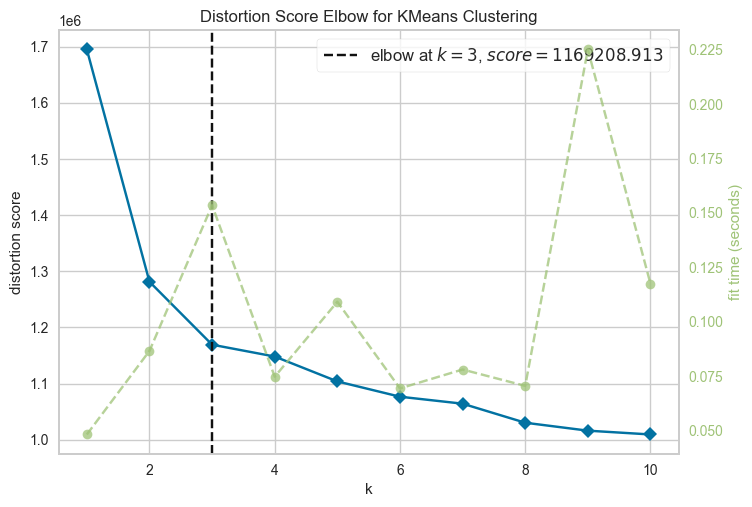

In [121]:
kmeans = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans, k=(1,11))

visualizer.fit(scaled_df)
_ = visualizer.show()

We also apply the **Silhouette Score method** to compare the results.

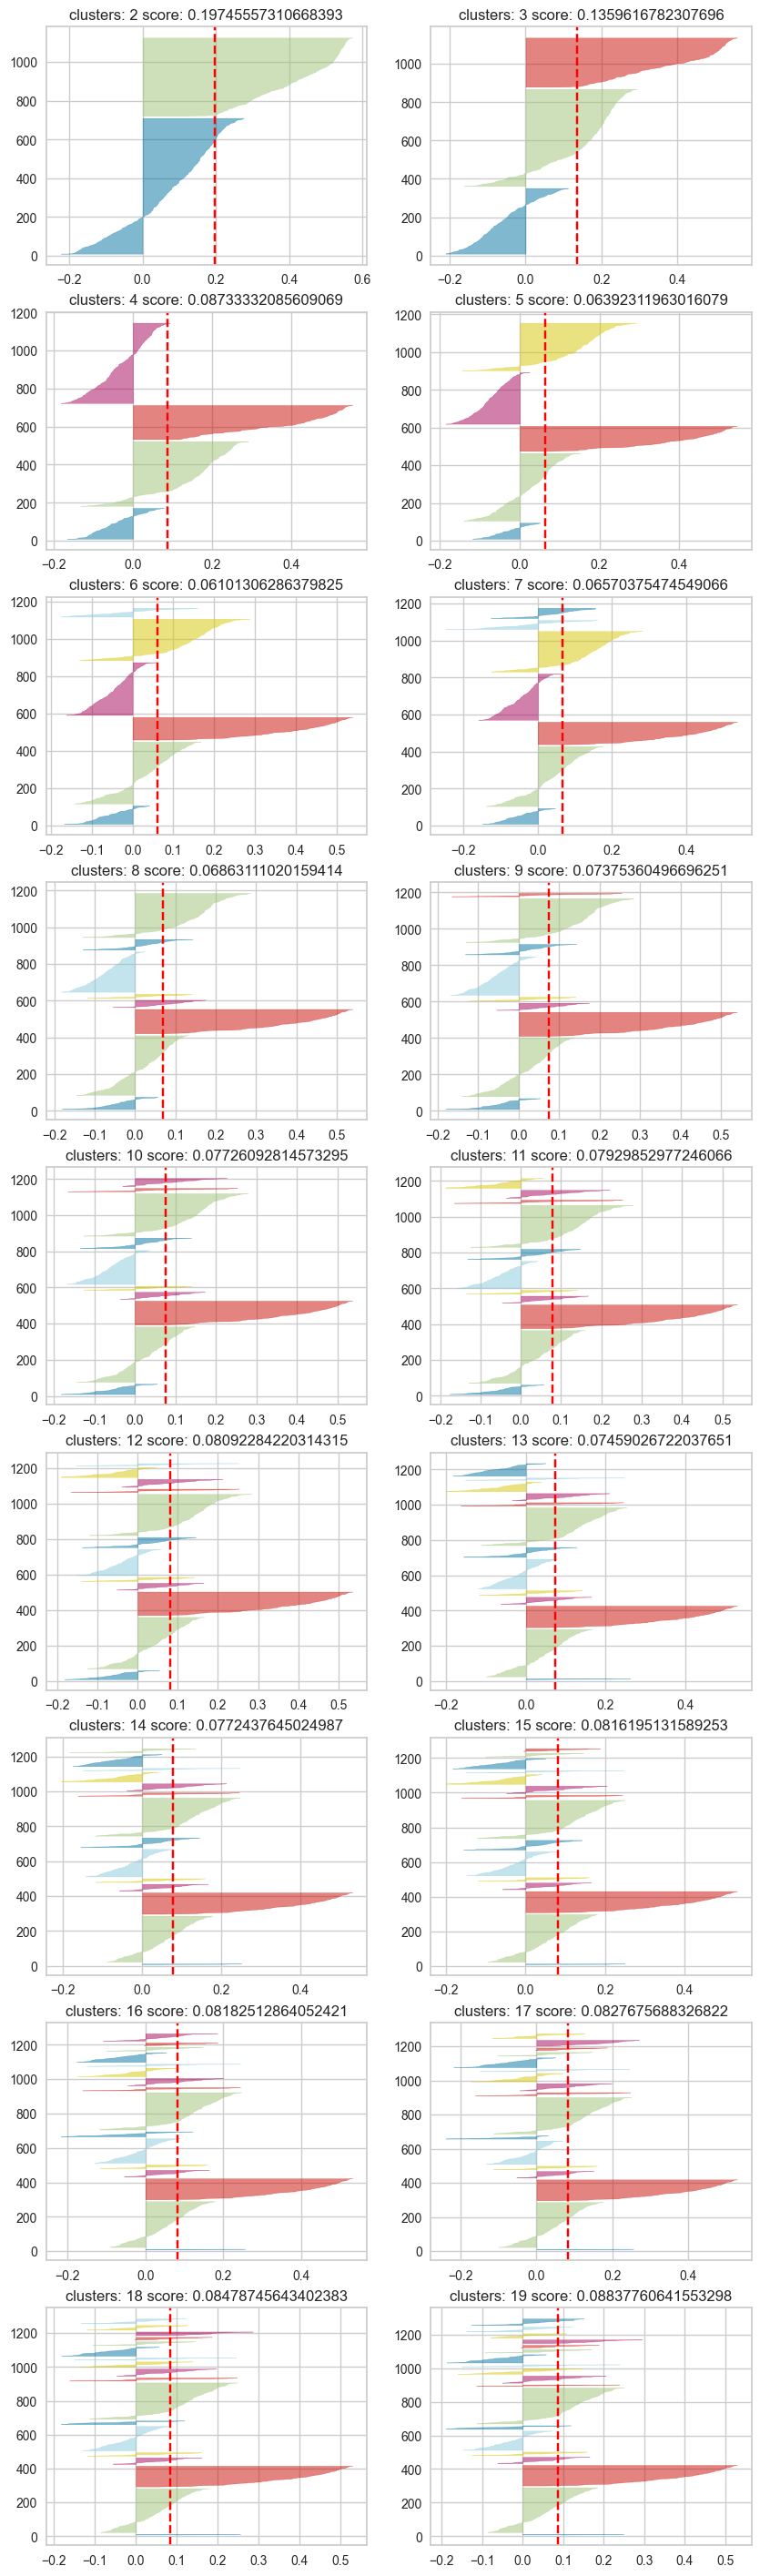

In [115]:
plt.figure(figsize=(2 * 5,  10 * 4))

scores = {}
for n_clusters in range(2, 20):
    plt.subplot(10, 2, n_clusters - 1)
    kmeans = KMeans(n_clusters, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(scaled_df)
    scores[n_clusters] = visualizer.silhouette_score_
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')

In [ ]:
# Sort the amount of clusters sorted by the overall score
sorted(scores.items(), key=lambda kv: kv[1], reverse=True)

[(2, 0.19745557310668393),
 (3, 0.1359616782307696),
 (19, 0.08837760641553298),
 (4, 0.08733332085609069),
 (18, 0.08478745643402383),
 (17, 0.0827675688326822),
 (16, 0.08182512864052421),
 (15, 0.0816195131589253),
 (12, 0.08092284220314315),
 (11, 0.07929852977246066),
 (10, 0.07726092814573295),
 (14, 0.0772437645024987),
 (13, 0.07459026722037651),
 (9, 0.07375360496696251),
 (8, 0.06863111020159414),
 (7, 0.06570375474549066),
 (5, 0.06392311963016079),
 (6, 0.06101306286379825)]

### Q2: Classification

Following the classification, the authors build a classifier to predict the class (defined as the cluster) of a song. The authors build their classifier using Random Forests and they use a series of models, described in Table 3. Do the same, for all models, using scikit-learn, XGBoost, LightGBM, and CatBoost. Report your results.

Beyond the tree-based classifiers, proceed to build a neural-network classifier using TensorFlow or PyTorch. Report also your results.

## Submission Instructions

You will submit a Jupyter notebook that will contain all your code, data, and analysis. Ensure that the notebook will run correctly in a computer that is not your own. That means, among other things, that it does not contain absolute paths. Remember that a notebook is not a collection of code cells thrown together; it should contain as much text as necessary for a person to understand what you are doing.

## Honor Code

You understand that this is an individual assignment, and as such you must carry it out alone. You may seek help on the Internet, on ChatGPT/Gemini/etc., by Googling or searching in StackOverflow for general questions pertaining to the use of Python and pandas libraries and idioms. However, it is not right to ask direct questions that relate to the assignment and where people will actually solve your problem by answering them. You may discuss with your colleagues in order to better understand the questions, if they are not clear enough, but you should not ask them to share their answers with you, or to help you by giving specific advice.